# Importing and reading data 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import integrate
import seaborn as sns; sns.set()

In [2]:
# be sure to git pull upstream master before reading the data so it is up to date.
DATA_URL = 'https://raw.githubusercontent.com/blas-ko/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

df_confirmed = pd.read_csv(DATA_URL+'time_series_19-covid-Confirmed.csv')
df_deaths = pd.read_csv(DATA_URL+'time_series_19-covid-Deaths.csv')
df_recovered = pd.read_csv(DATA_URL+'time_series_19-covid-Recovered.csv')

In [3]:
def df_to_timeseries(df):
    return df.drop(['Province/State','Lat','Long'], axis=1).groupby('Country/Region').sum().T

def df_to_timeseries_province(df):
    return df.drop(['Lat','Long'], axis=1).set_index('Country/Region')

def country_to_timeseries(df, country):
    return df.drop(['Lat','Long'],axis=1).set_index(['Country/Region','Province/State']).loc[country].T

def country_to_timeseries(df, country):
    df_country = df[ df['Country/Region'] == country ].drop(['Province/State','Lat','Long'], axis=1)
    
    return df_country.groupby('Country/Region').sum().T

def province_to_timeseries(df, province):
    df_province = df[ df['Province/State'] == province ] 
    
    return df_province.set_index('Province/State').drop(['Country/Region','Lat','Long'], axis=1).T#[province]

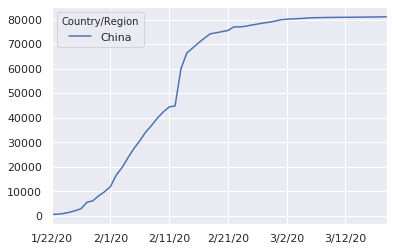

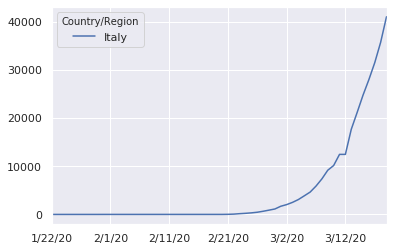

In [4]:
# testing...
country_to_timeseries(df_confirmed, 'China').plot()
country_to_timeseries(df_confirmed, 'Italy').plot()

# Basic model description
We use a SEIRD model to describe the spreading of the CoVid-19 virus in a population. The model distinguishes between the population that is Suceptible ($S$) to the virus, those who have been Exposed ($E$) to it but don't present any symptoms nor are infectious, those who are Infected ($I$), those who have Recovered ($R$), and those who are Deceased ($D$). This model is a simplification of the [compartamental model developed by Alison Hill and collaborators](https://alhill.shinyapps.io/COVID19seir/?fbclid=IwAR0G-qmOdznACkXRHZMMNyk4NRW-MHlk_n4I4W7Q3_MGqmm7wplUp0zpkJk)

The Suceptible population gets exposed to the virus by getting in contact with the Infected population at a rate $\lambda$. Then, the Exposed population get into an Infected stage at a rate $\sigma$. The Infected population can either Recover, which they do at a rate $\gamma$, or Die, which they do at a rate $\mu$. These dynamics are described in the following equations

\begin{align}
  \begin{aligned}
    \dot{S} &= -\lambda \frac{I}{N} S \\ 
    \dot{E} &= \lambda \frac{I}{N} S - \sigma E \\
    \dot{I} &= \sigma E - \gamma I - \mu I \\
    \dot{R} &= \gamma I \\
    \dot{D} &= \mu I,
  \end{aligned}
\end{align}
where $\dot{x} := \frac{dx(t)}{dt} $. Note that the equations implicitely encode that the conservation of the total population, i.e.
\begin{equation}
    S + E + I + R + D = N.
\end{equation}
This model assumes that, once an individual recovers, she will not get susceptible again. Further, we assume that the timescale of the epidemics is fast compared to the natural birth-death rates of the population. Thus, $N$ does not change in time (and, consequentially, it can be absorbed into $\lambda$). 

## Simulations 

In [5]:
# Basic SEIRD model ODE
def SEIRD_model(x, t, *params):
    λ, σ, γ, μ = params
    S,E,I,R,D = x
    return [-λ*I*S,
            λ*I*S - σ*E,
            σ*E - (γ+μ)*I,
            γ*I,
            μ*I]

## How to choose the coefficients and initial conditions of the model?

The **symptoms** of the coronavirus, according to the [Canadian public health service](https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/symptoms.html#s) and the [Worldometers](https://www.worldometers.info/coronavirus/coronavirus-symptoms/) suggest that 
- There are no vaccines yet 
- Symptoms may take up to 14 days to appear (there's a range between 2-14 days to develop symptoms according to the [CDC](https://www.cdc.gov/coronavirus/2019-ncov/symptoms-testing/symptoms.html?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov%2Fcoronavirus%2F2019-ncov%2Fabout%2Fsymptoms.html). We will use a exposure period of 8 days.
- The infection lasts around 14 days for mild cases and 3+ weeks for more severe cases
- 81 % of the cases are mild.

The **mortality** of the coronavirus, according to the [Worldometers](https://www.worldometers.info/coronavirus/coronavirus-death-rate/) includes:
- 3.4 % death rate as of March 03
- However, if one does the ratio of deaths/confirmed cases as of 20-March-2020, one gets 4 % death rate
- The recovery rate is around 35 % so far.

The **Basic reproductive ratio** (see [Wikipedia](https://en.wikipedia.org/wiki/Basic_reproduction_number)), according to the [CMMID](https://cmmid.github.io/topics/covid19/current-patterns-transmission/global-time-varying-transmission.html), is
- $R_0 \approx 2.2 \pm 0.2$ at 01/feb/20 in China
- $R_0 \approx 2.2 \pm 0.3$ at 01/feb/20 in Italy
- $R_0$ unknown at 01/feb/20 in the UK

Using the [World Bank transportation data](https://data.worldbank.org/indicator/IS.AIR.PSGR?locations=CN-IT-GB), we can estimate the flow between countries using as a proxy the average number of flights of any given country in 2018; these include
- China: $611$ million flights in 2018
- Italy: $28$ million flights in 2018
- UK: $165$ million flights in 2018

Specifically with travels between Italy and the UK, [Wikipedia](https://en.wikipedia.org/wiki/Italy%E2%80%93United_Kingdom_relations) says that  
- Between 4 and 5 million British tourists visit Italy every year. 
- 1 million Italian tourists visit the UK.
- [the UK government](https://www.gov.uk/foreign-travel-advice/italy) says that approximately 3 million British nationals visit Italy every year.


The population of countries can be found at the [Wordlometers](https://www.worldometers.info/world-population/population-by-country/), where
- China: $14.4 \times 10^9$ individuals
- Italy: $60.5 \times 10^6$ individuals
- UK: $67.9 \times 10^6$ individuals

The number of cases for each country are obtained from the [John Hopkins University repository](https://github.com/CSSEGISandData/COVID-19).

In [8]:
# Reported China coronavirus numbers on 01st February 2020
initial_date = '2/1/20'

N = 14.4e9    # China's population
cases = df_to_timeseries(df_confirmed).loc[initial_date,'China']    # total reported cases including resolved
deaths = df_to_timeseries(df_deaths).loc[initial_date,'China']
recovered = df_to_timeseries(df_recovered).loc[initial_date,'China']

R_0 = 2.3  # Basic Reproductive Rate [people]
M = 0.034   # Mortality ratio [fraction]
P_exposure = 8     # Average exposure period [days] (should really be split up by case severity)
P_infectious = 14     # Average exposure period [days] (should really be split up by case severity)

# Compute model coefficients
γ = 1 / P_infectious
μ = γ * M
λ = R_0 * (γ + μ)
σ = 1 / P_exposure 

# concatenating problem parameters
params = (λ, σ, γ, μ)

# setting initial conditions
r = 2 
R0 = recovered / N
D0 = deaths / N
I0 = cases/ N - R0 - D0  # confirmed cases
E0 = r*I0 # cases without symptoms, so they are not yet detected
S0 = (1 - E0 - I0 - R0 - D0)

# initial condition at t0 = Feb 01
x0 = [S0, E0, I0, R0, D0] 

In [9]:
## Integrating the problem for the next year
t0,tf = (0, 365)
sol = integrate.solve_ivp(lambda t,x: SEIRD_model(x, t, *params), (t0,tf), x0)

In [10]:
def plot_model(sol, country='China', log=False):
    # Basic plot of the dynamics
    plt.figure( figsize=(8,6) )

    labels = ['Suceptible', 'Exposed', 'Infected', 'Recovered', 'Deceased']
    for (i,y) in enumerate(sol.y):
        if i == 0:
            0
    #         continue
        plt.plot(sol.t, y*N, label=labels[i], lw=3)

    plt.title("Covid-19 spread in {}".format(country))
    plt.ylabel("Number of people")
    plt.xlabel("time [days since {}].".format(initial_date))
    plt.legend()
    
    if log:
        plt.yscale('log')
    
    print(f"For a population of {int(N/1e6)} million people, after {sol.t[-1]:.0f} days there were:")
    print(f"{sol.y[4][-1]*100:.1f}% total deaths, or {sol.y[4][-1]*N/1e3:.0f} thousand people.")
    print(f"{sol.y[3][-1]*100:.1f}% total recovered, or {sol.y[3][-1]*N/1e3:.0f} thousand people.")
    print(f"At the virus' maximum {sol.y[2].max()*100:.1f}% people were simultaneously infected, or {sol.y[2].max()*N/1e3:.0f} thousand people.")
    print(f"After {sol.t[-1]:.0f} days the virus was present in less than {sol.y[2][-1]*N/1e3:.0f} thousand individuals.")

If no measures are taken, according to our model:

For a population of 14400 million people, after 365 days there were:
2.8% total deaths, or 398435 thousand people.
81.4% total recovered, or 11718672 thousand people.
At the virus' maximum 12.5% people were simultaneously infected, or 1804362 thousand people.
After 365 days the virus was present in less than 158380 thousand individuals.


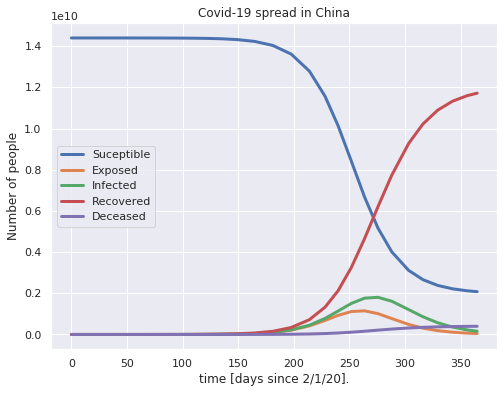

In [11]:
print("If no measures are taken, according to our model:\n")
plot_model(sol)

ToDo: Include measures of social distancing, quarantine, and the effect of the healthcare system. See [this notebook](https://github.com/TomNicholas/coronavirus/blob/master/covid-19_model.ipynb) for inspiration.

# SEIRD coupled model 

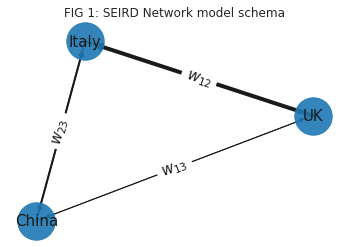

In [12]:
####----------------------------------####
#### Ilustration of the coupled model ####
####----------------------------------####
import networkx as nx

G = nx.DiGraph()
G.add_weighted_edges_from( [(1,2,4.0),(2,1, 2.0), (1,3, 1.0),(3,1, 1.0), (2,3, 1.5),(3,2, 2.0) ] )

pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1400, alpha=0.9)

# labels
nx.draw_networkx_labels(G, pos, labels={1:'UK',2:'Italy',3:'China'}, font_size=15, font_family='sans-serif')
# edges
edge_weights = []
for i in G.nodes:
    for j in G.nodes:
        if j != i:
            edge_weights.append( G[i][j]['weight'] )
nx.draw_networkx_edges(G, pos, width=edge_weights, )
# edge label
edge_labels = {(1,2): '$w_{12}$', (1,3): '$w_{13}$', (2,3): '$w_{23}$', }
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=15)

plt.axis('off')
plt.title("FIG 1: SEIRD Network model schema");

The Covid-19 is a pandemic, and, although the model $(1)$ takes a global population $N$ as its input, it does not have any structure of the interaction between the people. It is just a zeroth-order approximation of the rate of contact, and it assumes every suceptible individual has the same likelihood to get infected no matter where she is. 

Here we want to extend model $(1)$ and embed it into a network, where each of its nodes represents different populations and the edges represents the coupling between them. For instance, nodes may be countries while the edges rate at which people from one country travel to another.  

To simplify notation, we define the vector $\mathbf{x}^i = (S^i, E^i, I^i, R^i, D^i)$ to represent the population of country $i$.

$w_{ij}$ is the flow rate from country $i$ to country $j$. Only Suceptible and Exposed people should be able to travel (Of course Deceased and Infected people will not; but Recovered people were recently infectious, so they shouldn't travel anyways.). While the worldwide population is conserved --$N = \sum_i N^i$--, the population of each individual country can now vary over time.

$w_{ij}$ should be proportional to the individuals in country $i$, and the probability of going to country $j$ should decrease if $j$ has a lot of infected individual. Thus, we propose
\begin{equation}
    w_{ij} = \alpha_{ij} ( S^i + E^i ) e^{ - \beta I^j },
\end{equation}

where $\alpha_{ij}$ leverages the ammount of people that go from $i$ to $j$. If there's no epidemic (i.e. N^i = S^i), $w_{ij} = \alpha_{ij} S^i$ is the average number of flights per time unit from country $i$ to $j$. 

$\beta$ represents the intensity to not fly to country $j$ because of its infectiousness.  

Note that this rationale can be extended to any network structure, where, instead of taking the weight of a given country $i$ to every other country in the world, it only considers the set of $i$'s *possible* destinations, which we denote as $\mathcal{N}_i$. 

We incorporate the flows between countries to the basic SEIRD model described previously, obtaining the following system
\begin{align}
  \begin{aligned}
    \dot{S^i} &= -\lambda \frac{I^i}{N^i} S^i &- S^i \sum_{j \in \mathcal{N}_i} \alpha_{ij}e^{-\beta I^j} + \sum_{j \in \mathcal{N}_i} S^j \alpha_{ji}e^{-\beta I^i} \\ 
    \dot{E^i} &= \lambda \frac{I^i}{N^i} S^i - \sigma E^i & \underbrace{ - E^i \sum_{j \in \mathcal{N}_i} \alpha_{ij}e^{-\beta I^j} }_{\text{out-flow}} + \underbrace{ \sum_{j \in \mathcal{N}_i} E^j \alpha_{ji}e^{-\beta I^i} }_{\text{in-flow}} \\
    \dot{I^i} &= \sigma E^i - \gamma I^i - \mu I^i \\
    \dot{R^i} &= \gamma I^i \\
    \dot{D^i} &= \mu I^i,
  \end{aligned}
\end{align}
where we assume that the epidemic coefficients ($\lambda, \sigma, \gamma, \mu$) stay constant. 

Further, we will assume that the initial Exposed individuals are proportional to the infected (and officially registered) individuals. This is, 
\begin{equation}
E^i_0 = r (I^i_0 + R^i_0 + D^i_0),
\end{equation}
for some parameter $r \geq 1$. 

*Note that while the virus **may** affect the global population equally on average, different countries have developed different measures to stop the virus, effectively changing the epidemic coefficients. We will deal with those kind of measures later, when we parametrize the coefficients in terms of the action plan of each country*. 

ToDo: Do the coupled SEIRD for the general case on $k$ countries joined with an adj matrix (or maybe everybody fucks with everybody). $\alpha$ is a candidate for a weighted, directed adjacency whenever it's not constant. 

If $\alpha$ is constant, does everything couples exactly as we saw in the case of 2 countries?

In [13]:
# In the SEIRD model, each country comes packed in a vector of 5 components : S,E,I,R,D
def coupled_SEIRD(x, t, *params, coupling=True):
    α, β, λ, σ, γ, μ = params # could put A, adjmatrix
    
    n_countries = int( len(x)/5 )
    x_dot = []
    for i in range(n_countries):
        Si, Ei, Ii, Ri, Di = x[5*i:5*(i+1)]
        # decoupled SEIRD model
        Si_dot, Ei_dot, Ii_dot, Ri_dot, Di_dot = [-λ*Ii*Si, λ*Ii*Si - σ*Ei, σ*Ei - (γ+μ)*Ii, γ*Ii, μ*Ii]
        
        # couplings with other countries
        coupling_Si = 0
        coupling_Ei = 0
        if coupling:
            for j in range(n_countries):
                if i != j:
                    Sj, Ej, Ij, Rj, Dj = x[5*j:5*(j+1)]
                    coupling_Si += - Si * α[i,j] * np.exp( -β*Ij ) +  Sj * α[j,i] * np.exp( -β*Ii )  
                    coupling_Ei += - Ei * α[i,j] * np.exp( -β*Ij ) +  Ej * α[j,i] * np.exp( -β*Ii )
                
        Si_dot += coupling_Si
        Ei_dot += coupling_Ei
            
        x_dot += [Si_dot, Ei_dot, Ii_dot, Ri_dot, Di_dot]
        
    return x_dot

In [14]:
####-------------####
#### Model setup #### 
####-------------####
initial_date = '3/1/20'

N_uk = 67.8e6      # UK's population
cases_uk =  df_to_timeseries(df_confirmed).loc[initial_date,'United Kingdom']    # total reported cases including resolved
deaths_uk = df_to_timeseries(df_deaths).loc[initial_date,'United Kingdom']
recovered_uk = df_to_timeseries(df_recovered).loc[initial_date,'United Kingdom']
print("There were {} cases in the UK at {}".format(cases_uk, initial_date))

N_italy = 60.5e6    # Italy's population
cases_italy = df_to_timeseries(df_confirmed).loc[initial_date,'Italy']    # total reported cases including resolved
deaths_italy = df_to_timeseries(df_deaths).loc[initial_date,'Italy']
recovered_italy = df_to_timeseries(df_recovered).loc[initial_date,'Italy']
print("There were {} cases in Italy at {}".format(cases_italy, initial_date))

N_both = N_uk + N_italy

####----------------------------####
#### Estimation of coefficients #### 
####----------------------------####
R_0 = 2.5             # Basic Reproductive Rate [people]
M = 0.034             # Mortality ratio [fraction]
P_exposure = 8      # Average exposure period [days]
P_infectious = 16     # Average infectious period [days] (should really be split up by case severity)

## Estimation of model coefficients
# how to compute R0 taking P_exposure into account?
γ = 1 / P_infectious
σ = 1 / P_exposure 
μ = γ * M
λ = R_0 * (γ + μ + σ)
print("λ", λ)

## Estimation of coupling coefficients (source : https://data.worldbank.org/indicator/IS.AIR.PSGR?end=2018&locations=CN-IT&start=2006)
α_uk_italy = 4e6 / N_uk
α_italy_uk = 1e6 / N_italy 

α = np.array([ [0.0, α_uk_italy], [α_italy_uk, 0] ]) # transition matrix 
β = np.log(2) / 2e-4 # repulsion coefficient to fo to "infected" country. (made up)
# the logic behind β: if 10k people out of 50M are infected, reduce your chances of going by 1/2.
# i.e. exp( -β (10k/50M) ) ~ 1/2
print("β",β)

## MODEL PARAMETERS
params = (α, β, λ, σ, γ, μ)



####--------------------------####
#### Initial conditions setup #### 
####--------------------------####
r = 7 # Ratio of unregistered vs registered cases (made up quantity)
# UK
R0_uk = recovered_uk / N_both
D0_uk = deaths_uk / N_both
I0_uk = cases_uk/ N_both - R0_uk - D0_uk
E0_uk = r*I0_uk
S0_uk = (N_uk - E0_uk - I0_uk - R0_uk - D0_uk) / N_both

x0_uk = [S0_uk, E0_uk, I0_uk, R0_uk, D0_uk] 

# italy
R0_italy = recovered_italy / N_both
D0_italy = deaths_italy / N_both
I0_italy = cases_italy / N_both - R0_italy - D0_italy
E0_italy = r*I0_italy
S0_italy = (N_italy - E0_italy - I0_italy - R0_italy - D0_italy) / N_both

x0_italy = [S0_italy, E0_italy, I0_italy, R0_italy, D0_italy] 

### INITIAL CONDITIONS
x0 = x0_uk + x0_italy

There were 36 cases in the UK at 3/1/20
There were 1694 cases in Italy at 3/1/20
λ 0.47406249999999994
β 3465.7359027997263


In [15]:
####-----------------------------------####
#### Numerical simulation of the model #### 
####-----------------------------------####
days = 19
t0,tf = (0, days) # days from 01/feb to date : 29+20
# model with coupling
%time sol = integrate.solve_ivp(lambda t,x: coupled_SEIRD(x, t, *params, coupling=True), (t0,tf), x0, t_eval=np.linspace(0,days, days+1))
# model without coupling
%time sol_nocoupling = integrate.solve_ivp(lambda t,x: coupled_SEIRD(x, t, *params, coupling=False), (t0,tf), x0, t_eval=np.linspace(0,days, days+1))

It_uk, Rt_uk, Dt_uk = (sol.y[2], sol.y[3], sol.y[4])
It_it, Rt_it, Dt_it = (sol.y[2+5], sol.y[3+5], sol.y[4+5])

It_uk_noc, Rt_uk_noc, Dt_uk_noc = (sol_nocoupling.y[2], sol_nocoupling.y[3], sol_nocoupling.y[4])
It_it_noc, Rt_it_noc, Dt_it_noc = (sol_nocoupling.y[2+5], sol_nocoupling.y[3+5], sol_nocoupling.y[4+5])

print("\nCoupled scenario:")
print("Confirmed cases after {} days in UK: {}".format(days, (It_uk[-1] + Rt_uk[-1] + Dt_uk[-1])*N_both ) )
print("Confirmed cases after {} days in Italy: {}".format(days, (It_it[-1] + Rt_it[-1] + Dt_it[-1])*N_both ) )

print("\nDecoupled scenario:")
print("Confirmed cases after {} days in UK: {}".format(days, (It_uk_noc[-1] + Rt_uk_noc[-1] + Dt_uk_noc[-1])*N_both ) )
print("Confirmed cases after {} days in Italy: {}".format(days, (It_it_noc[-1] + Rt_it_noc[-1] + Dt_it_noc[-1])*N_both ) )

CPU times: user 5.34 ms, sys: 0 ns, total: 5.34 ms
Wall time: 3.99 ms
CPU times: user 0 ns, sys: 1.94 ms, total: 1.94 ms
Wall time: 1.6 ms

Coupled scenario:
Confirmed cases after 19 days in UK: 3357.1374698537497
Confirmed cases after 19 days in Italy: 38475.79502058507

Decoupled scenario:
Confirmed cases after 19 days in UK: 675.2092466621101
Confirmed cases after 19 days in Italy: 33601.8700472445


### Results of model: Coupled Scenario

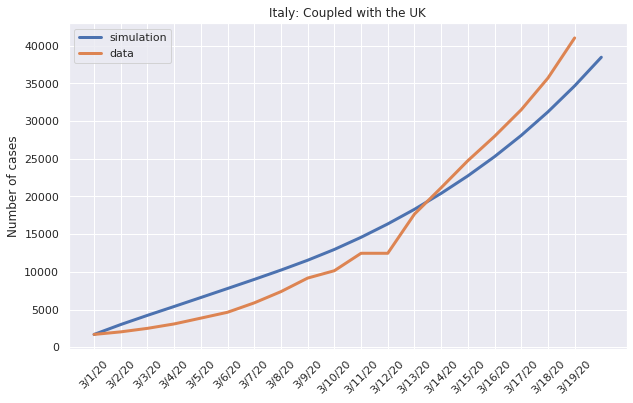

In [16]:
plt.figure( figsize=(10,6) )

# initial date is 3/1/20. The dataset starts at 1/22/20
days_till_initialdate = (31 - 22) + 29 + 1 # days from 1/22/20 to 3/1/20

plt.plot( sol.t, (It_it + Rt_it + Dt_it)*N_both, lw=3, label='simulation')
plt.plot(country_to_timeseries(df_confirmed, 'Italy').iloc[days_till_initialdate:], lw=3, label='data')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Number of cases")
plt.title('Italy: Coupled with the UK');

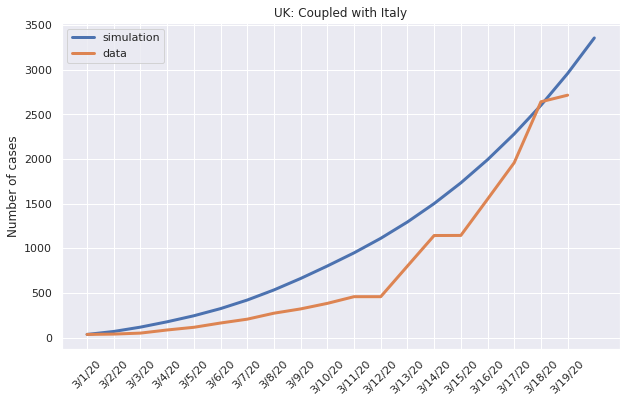

In [17]:
plt.figure( figsize=(10,6) )

plt.plot( sol.t, (It_uk + Rt_uk + Dt_uk)*N_both, lw=3, label='simulation')
plt.plot(country_to_timeseries(df_confirmed, 'United Kingdom').iloc[days_till_initialdate:], lw=3, label='data')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Number of cases")
plt.title('UK: Coupled with Italy');

Note that the model is already predicting the cases in Italy and the UK very well. A sensitive parameter in the model is controlling $r$, the ratio of exposed individuals (people with the virus but without symptoms) against the number of registered cases. We will see that in the decoupled scenario, Italy grows similarly as in the coupled case. However, the UK will not have enough exposure to the virus whenever it is decoupled, so the model will largely underestimate its number of cases.

Note that there is no preventive action in the considered in the model. This means that we may be highly underestimating the ratio $r$ of unregistered individual **already exposed** the virus. 

### No coupling scenario

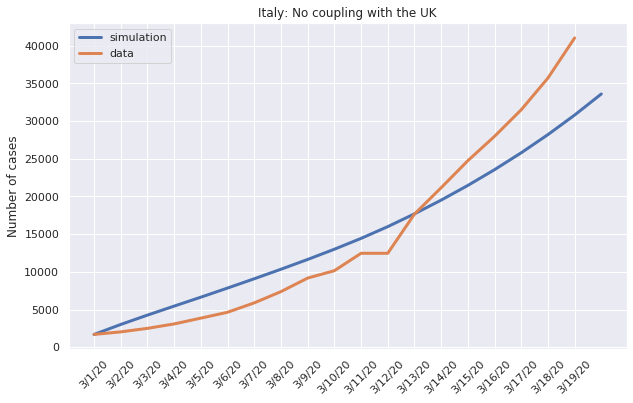

In [18]:
plt.figure( figsize=(10,6) )

plt.plot( sol.t, (It_it_noc + Rt_it_noc + Dt_it_noc)*N_both, lw=3, label='simulation')
plt.plot(country_to_timeseries(df_confirmed, 'Italy').iloc[days_till_initialdate:], lw=3, label='data')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Number of cases")
plt.title('Italy: No coupling with the UK');

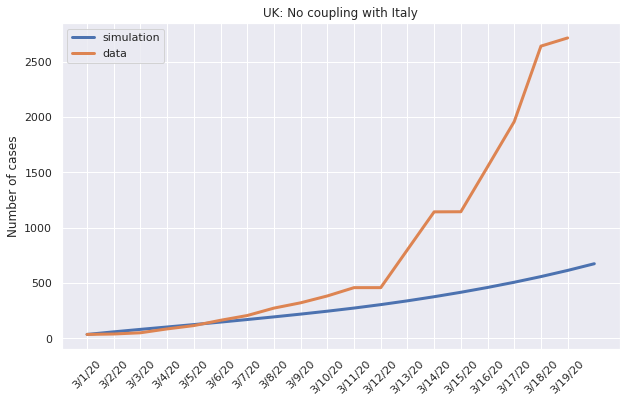

In [19]:
plt.figure( figsize=(10,6) )

plt.plot( sol.t, (It_uk_noc + Rt_uk_noc + Dt_uk_noc)*N_both, lw=3, label='simulation')
plt.plot(country_to_timeseries(df_confirmed, 'United Kingdom').iloc[days_till_initialdate:], lw=3, label='data')
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Number of cases")
plt.title('UK: No coupling with Italy');

## Long term dynamics (with no preventive action)

Some long term predictions of the model. These do not intend to have predictive power, I show them to see the effects of the coupling of the model.

In [20]:
####-----------------------------------####
#### Numerical simulation of the model #### 
####-----------------------------------####
days = 365
t0,tf = (0, days) # days from 01/feb to date : 29+20
%time sol = integrate.solve_ivp(lambda t,x: coupled_SEIRD(x, t, *params, coupling=True), (t0,tf), x0, t_eval=np.linspace(0,days, days+1))
%time sol_nocoupling = integrate.solve_ivp(lambda t,x: coupled_SEIRD(x, t, *params, coupling=False), (t0,tf), x0, t_eval=np.linspace(0,days, days+1))

It_uk, Rt_uk, Dt_uk = (sol.y[2], sol.y[3], sol.y[4])
It_it, Rt_it, Dt_it = (sol.y[2+5], sol.y[3+5], sol.y[4+5])

It_uk_noc, Rt_uk_noc, Dt_uk_noc = (sol_nocoupling.y[2], sol_nocoupling.y[3], sol_nocoupling.y[4])
It_it_noc, Rt_it_noc, Dt_it_noc = (sol_nocoupling.y[2+5], sol_nocoupling.y[3+5], sol_nocoupling.y[4+5])

CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 17 ms
CPU times: user 9.23 ms, sys: 0 ns, total: 9.23 ms
Wall time: 8.97 ms


Coupled scenario


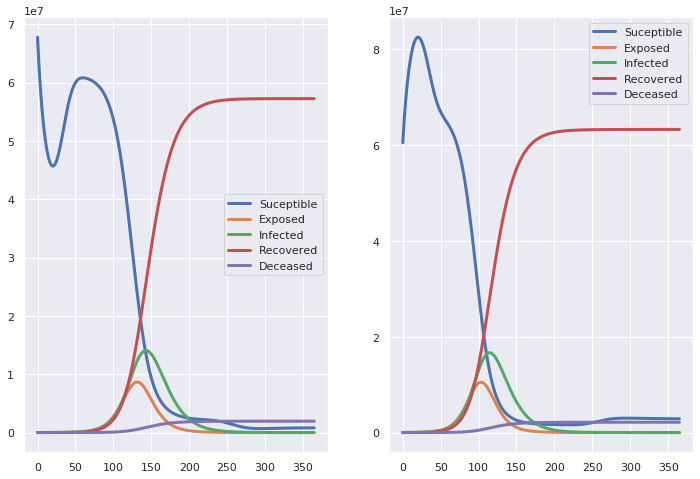

In [21]:
# Basic plot of the dynamics

fig, ax = plt.subplots(1, 2, figsize=(12,8))

labels = ['Suceptible', 'Exposed', 'Infected', 'Recovered', 'Deceased']
labels = labels*3
for (i,y) in enumerate(sol.y):
    if i%5 == 0:
        0
#         continue
    
    if i < 5:
        ax[0].plot(sol.t, y*N_both, label=labels[i], lw=3)
    else: 
        ax[1].plot(sol.t, y*N_both, label=labels[i], lw=3)

print("Coupled scenario")
        
ax[0].legend()
ax[1].legend()
# plt.yscale('log')

Decoupled scenario


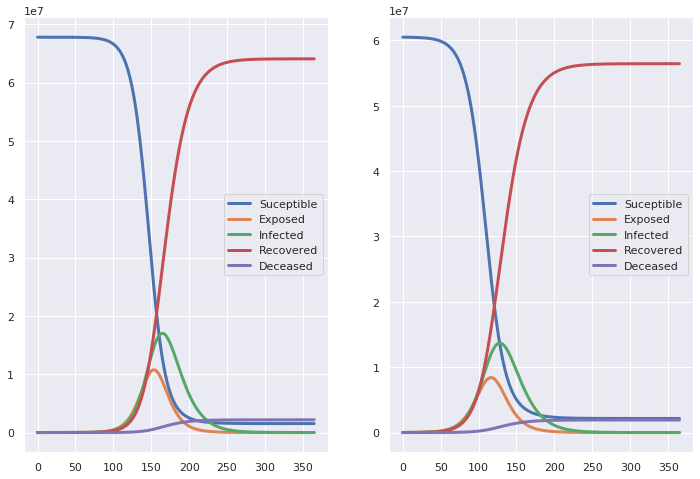

In [22]:
# Basic plot of the dynamics

fig, ax = plt.subplots(1, 2, figsize=(12,8))

labels = ['Suceptible', 'Exposed', 'Infected', 'Recovered', 'Deceased']
labels = labels*3
for (i,y) in enumerate(sol_nocoupling.y):
    if i%5 == 0:
        0
#         continue
    
    if i < 5:
        ax[0].plot(sol_nocoupling.t, y*N_both, label=labels[i], lw=3)
    else: 
        ax[1].plot(sol_nocoupling.t, y*N_both, label=labels[i], lw=3)

print("Decoupled scenario")
        
ax[0].legend()
ax[1].legend()
# plt.yscale('log')

Of course this projections are not realistic. They assume that most of the population will be affected after one year time (this could indeed be possible if there is no preventive action at all). Further, the coupled case should be corrected because a substantial part of the country's population flights to the neighbouring countries. We should model a return-flight model (maybe with time delays over $S(t)$ and $E(t)$. 